# Machine learning model to read reviews

Question: how can we analyze a large number or reviews with NPL?

Goal: enable companies to quickly extract the key topics covered from the customer feedback without having to read through them one by one

In [1]:
# 1 Import dependencies
from sqlalchemy import create_engine
import pandas as pd
import spacy

# Libraries for visualization
import matplotlib.pyplot as plt
import seaborn as sns
import pyLDAvis
import pyLDAvis.gensim_models
%matplotlib inline

# Libraries for lemmatization
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk import FreqDist

# Libraries for word cloud
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [2]:
# 2 Postgres username, password, and database name
POSTGRES_ADDRESS = 'mypostgresdb.cwuhtytzosg8.us-east-2.rds.amazonaws.com' 
POSTGRES_PORT = '5432'
POSTGRES_USERNAME = 'root' 
POSTGRES_PASSWORD = 'XXXX' ## CHANGE THIS TO YOUR PANOPLY/POSTGRES PASSWORD
POSTGRES_DBNAME = 'my_data_class_db'
# A long string that contains the necessary Postgres login information
postgres_str = ('postgresql://{username}:{password}@{ipaddress}:{port}/{dbname}'
.format(username=POSTGRES_USERNAME,
password=POSTGRES_PASSWORD,
ipaddress=POSTGRES_ADDRESS,
port=POSTGRES_PORT,
dbname=POSTGRES_DBNAME))
# Create the connection
cnx = create_engine(postgres_str)

C:\Users\li_mi\anaconda3\envs\PythonData\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
# 3 Load database for sentiment/topic analysis
df = pd.read_sql_query('''SELECT * FROM airmattress_cleaned_v2''', con=cnx)
df.head()

C:\Users\li_mi\anaconda3\envs\PythonData\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,customer_id,review_id,star_rating,review_body
0,46619816,R3A3BMMWFE53L7,2,i wouldnt really recommend this to anyone i sl...
1,44543268,ROHMHI9495XEX,5,we bought this to use in our cottage for overf...
2,41744720,R1Z8PESIUO0LP9,5,buenos dias todo llego en excelente estado un ...
3,28904296,R3O69V6PAADOYQ,5,smaller than the standard bed but just as elev...
4,35675695,R2ESZJ83S1SZE6,2,bought this for the occasional guest the firs...


### Prepare data for ML model

In [4]:
# 4 function to plot most frequent terms
def freq_words(x, terms = 30):
  all_words = ' '.join([text for text in x])
  all_words = all_words.split()

  fdist = FreqDist(all_words)
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})

  # selecting top 20 most frequent words
  d = words_df.nlargest(columns="count", n = terms) 
  plt.figure(figsize=(20,5))
  ax = sns.barplot(data=d, x= "word", y = "count", color = 'black')
  ax.set(ylabel = 'Count')
  plt.show()

C:\Users\li_mi\anaconda3\envs\PythonData\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


C:\Users\li_mi\anaconda3\envs\PythonData\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


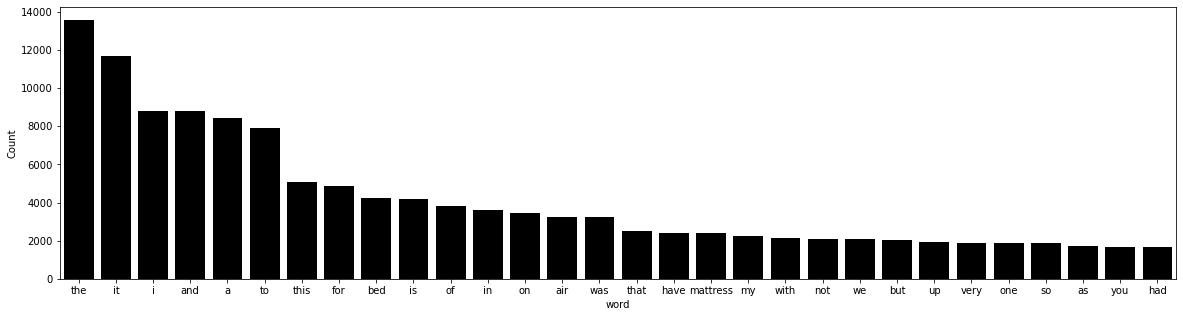

In [5]:
freq_words(df['review_body'])

In [6]:
# 5 Remove unwanted characters, numbers and symbols
df['review_body'] = df['review_body'].str.replace("[^a-zA-Z#]", " ")
df

C:\Users\li_mi\anaconda3\envs\PythonData\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\Users\li_mi\anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


,customer_id,review_id,star_rating,review_body
0,46619816,R3A3BMMWFE53L7,2,i wouldnt really recommend this to anyone i sl...
1,44543268,ROHMHI9495XEX,5,we bought this to use in our cottage for overf...
2,41744720,R1Z8PESIUO0LP9,5,buenos dias todo llego en excelente estado un ...
3,28904296,R3O69V6PAADOYQ,5,smaller than the standard bed but just as elev...
4,35675695,R2ESZJ83S1SZE6,2,bought this for the occasional guest the firs...
...,...,...,...,...
4748,5321582,RHU6FFPXQNKJ2,5,this air mattress has lived up to the reviews ...
4749,15194578,R3P9TAJZHPOBNF,5,bought this bed to replace a smaller one my g...
4750,14259748,R30NB7N9JA0059,5,this is a wonderful bed nice height for those ...
4751,36004883,R3H248QXLMRDBI,5,ive been looking for the right one and ive fou...


In [7]:
# 6 Remove stop words
stop_words = nltk.corpus.stopwords.words('english')

# Remove stopwords
def remove_stopwords(rev):
    rev_new = " ".join([i for i in rev if i not in stop_words])
    return rev_new

# Remove short words (length < 3)
df['review_body'] = df['review_body'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))

# Exclude stopwords from the text
reviews = [remove_stopwords(r.split()) for r in df['review_body']]

C:\Users\li_mi\anaconda3\envs\PythonData\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [8]:
# 7 To remove noise from reviews, use lemmatization from spaCy library
!python -m spacy download en_core_web_sm 

C:\Users\li_mi\anaconda3\envs\PythonData\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


2021-05-20 17:40:12.319031: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2021-05-20 17:40:12.319059: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [9]:
# 8 Use nlp to remove words that are not aggregating to analysis, using only adjectives
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# def lemmatization(texts, tags=['NOUN', 'ADJ']): # filter noun and adjective
def lemmatization(texts, tags=['ADJ']): # filter adjective only
       output = []
       for sent in texts:
             doc = nlp(" ".join(sent)) 
             output.append([token.lemma_ for token in doc if token.pos_ in tags])
       return output

C:\Users\li_mi\anaconda3\envs\PythonData\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [10]:
tokenized_reviews = pd.Series(reviews).apply(lambda x: x.split())
print(tokenized_reviews[1])

['bought', 'use', 'cottage', 'overflow', 'guests', 'possibly', 'camping', 'big', 'sturdy', 'used', 'say', 'comfy', 'built', 'pump', 'keeps', 'inflated']


C:\Users\li_mi\anaconda3\envs\PythonData\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [11]:
reviews_2 = lemmatization(tokenized_reviews)
print(reviews_2[1]) # print lemmatized review

C:\Users\li_mi\anaconda3\envs\PythonData\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['big']


C:\Users\li_mi\anaconda3\envs\PythonData\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


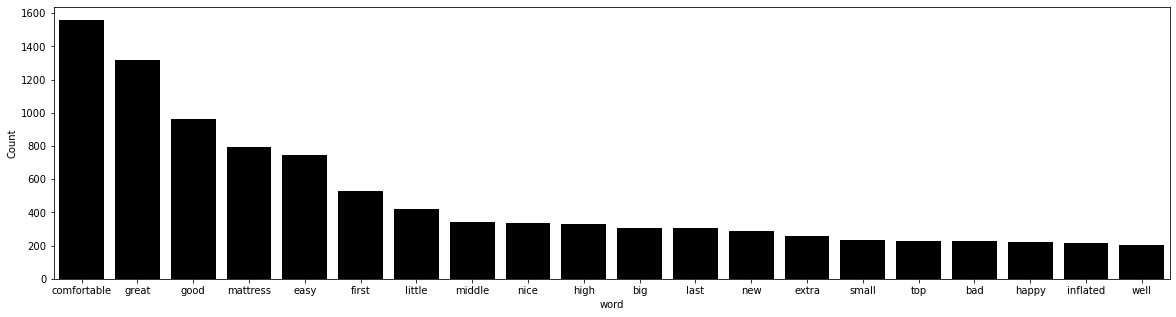

In [12]:
# 9 Show word count after reviews clean up
reviews_3 = []
for i in range(len(reviews_2)):
    reviews_3.append(' '.join(reviews_2[i]))

df['reviews'] = reviews_3

freq_words(df['reviews'], 20)

It will be easier to understand good and bad customer feedback if we break the analysis into good reviews and bad reviews

### Develop 2 separate analysis: good reviews from bad reviews

Create 2 dataframes, one with only 1 star reviews and another with 2 star reviews to get a better sense of the good and bad feedback

In [13]:
# 10 Create df for only bad reviews, 1-star
df_1star = df[df['star_rating'] == 1]
df_1star.head()

C:\Users\li_mi\anaconda3\envs\PythonData\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,customer_id,review_id,star_rating,review_body,reviews
8,14889565,R1PA2HW7F8PDGB,1,use this minimally and gently and still has le...,
10,5296079,R1FIM342M1F0RK,1,the motor blew smoke and seized the first time...,first inchesbr upsetting
15,29310577,R1CI5H0J0SHQ5D,1,past days returning this product and feel very...,past first many
18,48424572,R3M7DQQ3FQ5R8Q,1,they send broken one slept for the first night...,first soft soft
25,32183183,R2WC8ZEHASTT09,1,just purchased the product since would staying...,spare sleep good sure closed next much


In [14]:
# 11 Create df for only good reviews, 5-stars
df_5stars = df[df['star_rating'] == 5]
df_5stars.head()

C:\Users\li_mi\anaconda3\envs\PythonData\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,customer_id,review_id,star_rating,review_body,reviews
1,44543268,ROHMHI9495XEX,5,bought this use our cottage for overflow guest...,big
2,41744720,R1Z8PESIUO0LP9,5,buenos dias todo llego excelente estado produc...,todo
3,28904296,R3O69V6PAADOYQ,5,smaller than the standard bed but just elevate...,small standard fine
6,42038243,R2HO1DTWEAERPW,5,needed extra bed for grandchildrens visit the ...,extra fast great extra
7,35162694,R1BZ1AUK399N9P,5,love the bed exactly described very comfortabl...,comfortable


In [15]:
# 12 Remove unwanted characters, numbers and symbols
df_1star['review_body'] = df['review_body'].str.replace("[^a-zA-Z#]", " ")
df_5stars['review_body'] = df['review_body'].str.replace("[^a-zA-Z#]", " ")

C:\Users\li_mi\anaconda3\envs\PythonData\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\Users\li_mi\anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  
C:\Users\li_mi\anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\li_mi\anaconda3\envs\PythonData\lib\site-packages\ipykernel_l

In [16]:
# 13 Remove stopwords
new_stopwords = ["first", "mattress", "second", "last"]
stop_words = nltk.corpus.stopwords.words('english')
stop_words.extend(new_stopwords)

def remove_stopwords(rev):
    rev_new = " ".join([i for i in rev if i not in stop_words])
    return rev_new

# Exclude stopwords from the text
reviews_1star = [remove_stopwords(r.split()) for r in df_1star['review_body']]
reviews_5stars = [remove_stopwords(r.split()) for r in df_5stars['review_body']]

C:\Users\li_mi\anaconda3\envs\PythonData\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [17]:
# 14 Use nlp to remove words that are not aggregating to analysis, using only adjectives
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# def lemmatization(texts, tags=['NOUN', 'ADJ']): # filter noun and adjective
def lemmatization(texts, tags=['ADJ']): # filter noun and adjective
       output = []
       for sent in texts:
             doc = nlp(" ".join(sent)) 
             output.append([token.lemma_ for token in doc if token.pos_ in tags])
       return output

C:\Users\li_mi\anaconda3\envs\PythonData\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [18]:
tokenized_reviews_1star = pd.Series(reviews_1star).apply(lambda x: x.split())
tokenized_reviews_5stars = pd.Series(reviews_5stars).apply(lambda x: x.split())
print(tokenized_reviews_1star[1])
print(tokenized_reviews_5stars[1])

['motor', 'blew', 'smoke', 'seized', 'time', 'tried', 'inflate', 'bed', 'inflate', 'inchesbr', 'upsetting']
['buenos', 'dias', 'todo', 'llego', 'excelente', 'estado', 'producto', 'buena', 'calidad', 'fue', 'entregado', 'tiempo', 'con', 'las', 'caracteristicas', 'solicitadas']


C:\Users\li_mi\anaconda3\envs\PythonData\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [19]:
reviews_1star_2 = lemmatization(tokenized_reviews_1star)
reviews_5stars_2 = lemmatization(tokenized_reviews_5stars)

print(reviews_1star_2[1]) 
print(reviews_5stars_2[1]) 

C:\Users\li_mi\anaconda3\envs\PythonData\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['inchesbr', 'upsetting']
['todo']


C:\Users\li_mi\anaconda3\envs\PythonData\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\Users\li_mi\anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


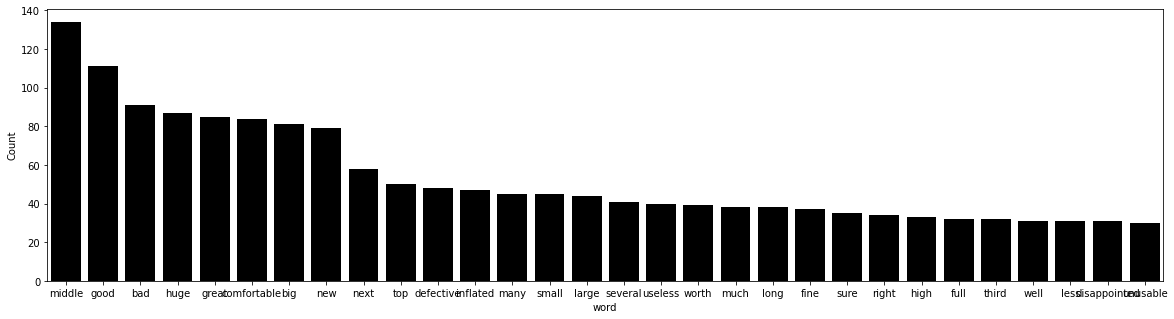

In [20]:
# 15 Create chart frequent words for 1 star reviews
reviews_1star_3 = []
for i in range(len(reviews_1star_2 )):
    reviews_1star_3.append(' '.join(reviews_1star_2[i]))

df_1star['reviews'] = reviews_1star_3

freq_words(df_1star['reviews'], 30)

C:\Users\li_mi\anaconda3\envs\PythonData\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\Users\li_mi\anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


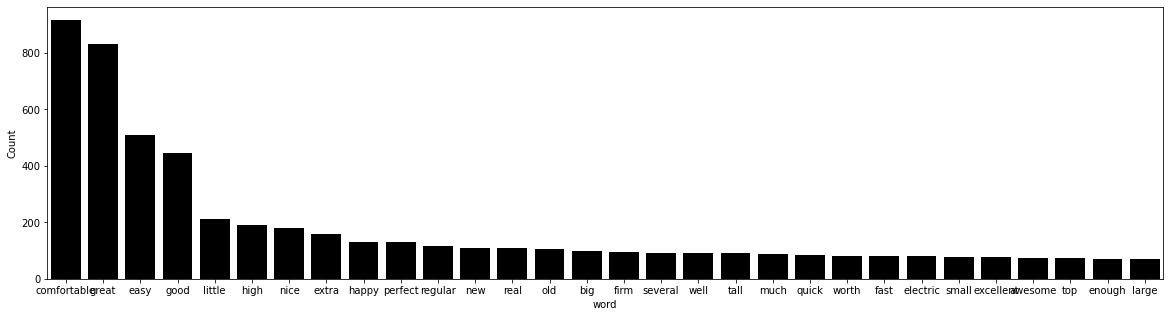

In [21]:
# 16 Create chart frequent words for 5 star reviews
reviews_5stars_3 = []
for i in range(len(reviews_5stars_2 )):
    reviews_5stars_3.append(' '.join(reviews_5stars_2[i]))

df_5stars['reviews'] = reviews_5stars_3

freq_words(df_5stars['reviews'], 30)

### Create Latent Dirichlet Allocation (LDA) model

One application of LDA in machine learning - specifically, topic discovery, a subproblem in natural language processing - is to discover topics in a collection of documents, and then automatically classify any individual document within the collection in terms of how "relevant" it is to each of the discovered topics. A topic is considered to be a set of terms (i.e., individual words or phrases) that, taken together, suggest a shared theme. Souce: Wikipedia

Topic Modelling is different from rule-based text mining approaches that use regular expressions or dictionary based keyword searching techniques. It is an unsupervised approach used for finding and observing the bunch of words (called “topics”) in large clusters of texts. Source: https://www.analyticsvidhya.com/blog/2016/08/beginners-guide-to-topic-modeling-in-python/

In [22]:
# 17 Import dependencies for LDA model
import gensim
from gensim import corpora

C:\Users\li_mi\anaconda3\envs\PythonData\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\Users\li_mi\anaconda3\envs\PythonData\lib\site-packages\scipy\sparse\sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()
C:\Users\li_mi\anaconda3\envs\PythonData\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.wa

In [23]:
# 18 Create the term dictionary of our corpus, unique terms are assigned an index
dictionary_1star = corpora.Dictionary(reviews_1star_2)
dictionary_5stars = corpora.Dictionary(reviews_5stars_2)

C:\Users\li_mi\anaconda3\envs\PythonData\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [24]:
# 19 Transform list of reviews into a document term matrix
doc_term_matrix_1star = [dictionary_1star.doc2bow(rev) for rev in reviews_1star_2]
doc_term_matrix_5stars = [dictionary_5stars.doc2bow(rev) for rev in reviews_5stars_2]

C:\Users\li_mi\anaconda3\envs\PythonData\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [25]:
# 20 Creating the object for LDA model using gensim library
LDA = gensim.models.ldamodel.LdaModel

# Build LDA model. In this case we specifified # of topics = 4 and 3 (reassessed after viz)
lda_model_1star = LDA(corpus=doc_term_matrix_1star, id2word=dictionary_1star, num_topics=4, random_state=100,
                chunksize=1000, passes=50)

lda_model_5stars = LDA(corpus=doc_term_matrix_5stars, id2word=dictionary_5stars, num_topics=3, random_state=100,
                chunksize=1000, passes=50)

C:\Users\li_mi\anaconda3\envs\PythonData\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [26]:
# 21 Print topics 1 star
lda_model_1star.print_topics()

C:\Users\li_mi\anaconda3\envs\PythonData\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0,
  '0.053*"good" + 0.039*"new" + 0.029*"worth" + 0.029*"defective" + 0.027*"much" + 0.022*"many" + 0.022*"several" + 0.021*"flat" + 0.020*"sure" + 0.015*"half"'),
 (1,
  '0.071*"middle" + 0.029*"high" + 0.019*"top" + 0.018*"long" + 0.017*"small" + 0.017*"electric" + 0.017*"downy" + 0.017*"huge" + 0.016*"loose" + 0.015*"unusable"'),
 (2,
  '0.077*"bad" + 0.041*"comfortable" + 0.027*"inflated" + 0.025*"third" + 0.024*"next" + 0.021*"good" + 0.014*"due" + 0.014*"happy" + 0.013*"small" + 0.012*"top"'),
 (3,
  '0.049*"big" + 0.048*"great" + 0.040*"middle" + 0.038*"huge" + 0.021*"disappointed" + 0.019*"comfortable" + 0.018*"large" + 0.017*"well" + 0.016*"new" + 0.016*"full"')]

In [27]:
# 22 Print topics 5 stars
lda_model_5stars.print_topics()

C:\Users\li_mi\anaconda3\envs\PythonData\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0,
  '0.134*"great" + 0.111*"good" + 0.078*"comfortable" + 0.035*"perfect" + 0.023*"extra" + 0.022*"little" + 0.021*"tall" + 0.018*"awesome" + 0.018*"large" + 0.017*"full"'),
 (1,
  '0.038*"new" + 0.037*"regular" + 0.035*"comfortable" + 0.032*"old" + 0.031*"happy" + 0.029*"much" + 0.029*"well" + 0.023*"bad" + 0.020*"little" + 0.017*"cold"'),
 (2,
  '0.120*"easy" + 0.107*"comfortable" + 0.062*"great" + 0.039*"nice" + 0.034*"high" + 0.024*"firm" + 0.020*"big" + 0.020*"electric" + 0.020*"little" + 0.018*"fast"')]

### Topics visualization

In [28]:
# 23 Visualize topics for 1 star
pyLDAvis.enable_notebook()

vis = pyLDAvis.gensim_models.prepare(lda_model_1star, doc_term_matrix_1star, dictionary_1star)

vis

C:\Users\li_mi\anaconda3\envs\PythonData\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.098647  0.076734       1        1  30.745897
0      0.102328  0.110802       2        1  24.748711
2      0.126440 -0.109802       3        1  24.374698
1     -0.130121 -0.077734       4        1  20.130694, topic_info=              Term        Freq       Total Category  logprob  loglift
126            bad   76.000000   76.000000  Default  30.0000  30.0000
26          middle  114.000000  114.000000  Default  29.0000  29.0000
22             big   68.000000   68.000000  Default  28.0000  28.0000
54           great   72.000000   72.000000  Default  27.0000  27.0000
64            high   28.000000   28.000000  Default  26.0000  26.0000
..             ...         ...         ...      ...      ...      ...
60   uncomfortable    5.242616   17.728787   Topic4  -5.0507   0.3846
20             new    6.066974   67.391322   Topic4  -4.9046  -0.8047
42           right    5.103982   29.447309   Topic4  -5.0775  -0.1497
9             next    5.191422   49.466302   Topic4  -5.0605  -0.6514
54           great    4.670326   72.396873   Topic4  -5.1663  -1.1380

[261 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
113       1  0.347392        able
113       2  0.397019        able
113       3  0.248137        able
198       1  0.791706    absolute
483       1  0.791776  acceptable
...     ...       ...         ...
175       2  0.861734       worth
175       3  0.089145       worth
175       4  0.029715       worth
205       3  0.898163      worthy
169       2  0.713354       young

[355 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 1, 3, 2])

In [29]:
# 23.1 Export to html
lda_model_1star=open('lda_model_1star.html', 'w')
pyLDAvis.save_html(vis, lda_model_1star)

C:\Users\li_mi\anaconda3\envs\PythonData\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [30]:
# 24 Visualize topics for 5 stars
pyLDAvis.enable_notebook()

vis = pyLDAvis.gensim_models.prepare(lda_model_5stars, doc_term_matrix_5stars, dictionary_5stars)

vis

C:\Users\li_mi\anaconda3\envs\PythonData\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.076333 -0.195470       1        1  38.659554
0     -0.168030  0.152006       2        1  34.663864
1      0.244363  0.043464       3        1  26.676581, topic_info=         Term        Freq       Total Category  logprob  loglift
21       easy  468.000000  468.000000  Default  30.0000  30.0000
24       good  389.000000  389.000000  Default  29.0000  29.0000
7       great  711.000000  711.000000  Default  28.0000  28.0000
53        new  104.000000  104.000000  Default  27.0000  27.0000
66    regular  100.000000  100.000000  Default  26.0000  26.0000
..        ...         ...         ...      ...      ...      ...
16      queen   21.298363   48.527264   Topic3  -4.8411   0.4979
11       nice   32.372079  183.340382   Topic3  -4.4224  -0.4127
318  inflated   23.361455   74.787225   Topic3  -4.7486   0.1578
68       high   27.158574  162.210835   Topic3  -4.5980  -0.4658
39       long   20.277110   44.972278   Topic3  -4.8902   0.5248

[176 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
131       1  0.643296        able
131       3  0.352775        able
379       2  0.970407      actual
299       3  0.959842  additional
248       2  0.977859  adjustable
...     ...       ...         ...
84        1  0.957780       whole
159       3  0.983042   wonderful
13        1  0.356841       worth
13        2  0.634384       worth
241       1  0.975530       young

[176 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 2])

In [31]:
# 24.1 Export to html
lda_model_5stars=open('5star_lda.html', 'w')
pyLDAvis.save_html(vis, lda_model_5stars)

C:\Users\li_mi\anaconda3\envs\PythonData\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


C:\Users\li_mi\anaconda3\envs\PythonData\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


There are 28215 words in the combination of all cells in column reviews for 1-star.


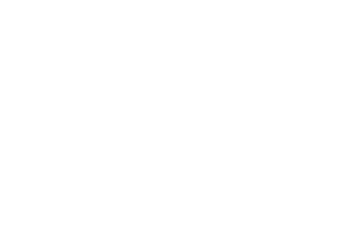

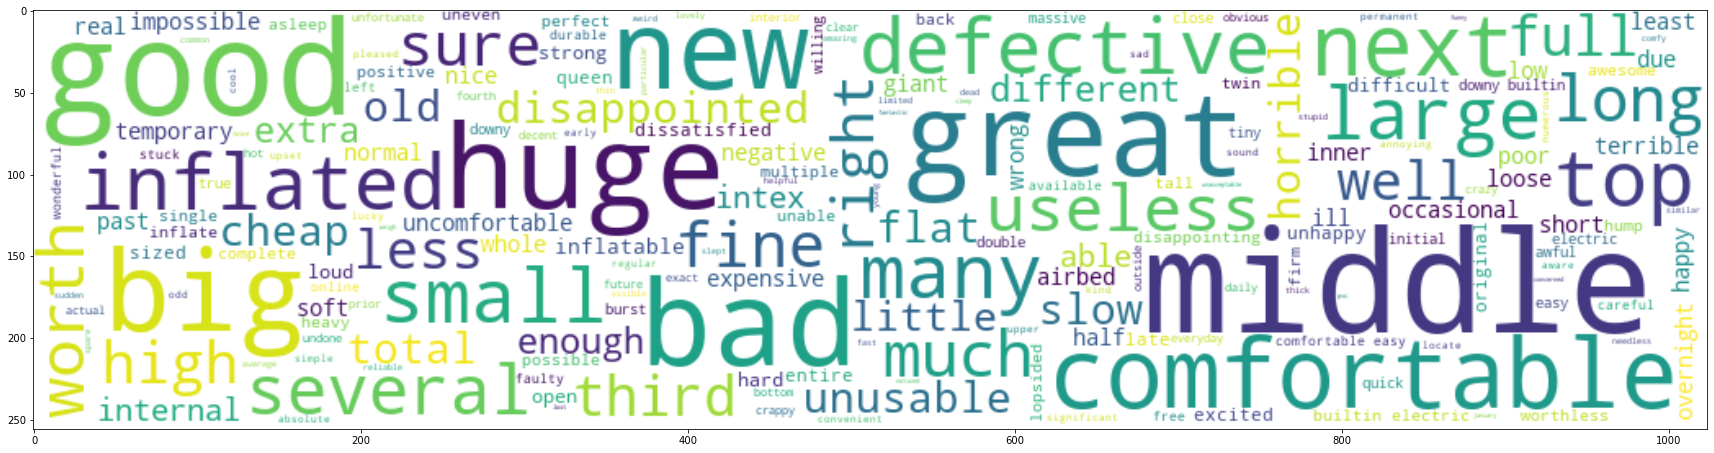

In [32]:
# 25 Create word cloud for 1 star reviews
# Text of all words in column customer reviews

text = " ".join(review for review in df_1star.reviews.astype(str))
print ("There are {} words in the combination of all cells in column reviews for 1-star.".format(len(text)))


# Generate a word cloud image
wordcloud = WordCloud(background_color="white", width=1024, height=256).generate(text)

# Display the generated image:
# the matplotlib way:

plt.axis("off")
plt.figure( figsize=(30,10))
plt.tight_layout(pad=0)
plt.imshow(wordcloud, interpolation='bilinear')
plt.show()

In [ ]:
# 26 Create word cloud for 5 star reviews
# Text of all words in column customer reviews

text = " ".join(review for review in df_5stars.reviews.astype(str))
print ("There are {} words in the combination of all cells in column reviews for 5-stars.".format(len(text)))


# Generate a word cloud image
wordcloud = WordCloud(background_color="white", width=1024, height=256).generate(text)

# Display the generated image:
# the matplotlib way:

plt.axis("off")
plt.figure( figsize=(30,10))
plt.tight_layout(pad=0)
plt.imshow(wordcloud, interpolation='bilinear')
plt.show()

C:\Users\li_mi\anaconda3\envs\PythonData\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


There are 71480 words in the combination of all cells in column reviews for 5-stars.
